In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class Patch(object):
    """
    Creates patches from images
    """

    def __init__(self, patch_size=14):
      self.patch_size = patch_size

    def __call__(self, image):
      #print("hello")
      #print(image)
      #print(image.shape)
      patched_image = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
      # patched_image = rearrange(image.unsqueeze(0), 'b c (h h1) (w w1) -> (b h1 w1) c h w', h1=2,w1=2)
      # patched_image = rearrange(F.unfold(image, patch_size, patch_size), '(h w) c -> c h w', h=patch_size)
      v = torch.flatten(patched_image)
      #print(v)
      patched_image = torch.reshape(v,(4,14,14))
      #print(patched_image.shape)
      #print(patched_image)

      return patched_image

In [ ]:
#transform = transforms.ToTensor()

transform = transforms.Compose([
     transforms.ToTensor(),
     Patch(),
 ])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)



  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 12034884.28it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33490653.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 12211877.42it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [ ]:
dataiter = iter(data_loader)
images_ref, labels_ref = next(dataiter)
print(images_ref.shape)
print(torch.min(images_ref), torch.max(images_ref))
print(type(labels_ref[0].item()))

torch.Size([64, 4, 14, 14])
tensor(0.) tensor(1.)
<class 'int'>


In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(14 * 14, 16), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 14 * 14)
            #nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded



In [ ]:
model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
lat_rep_dim = 1 #Change based on number of latent rep

In [ ]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        model.train()
        img = img.reshape(-1, 14*14)
        recon,encoded = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))


Epoch:1, Loss:0.0619
Epoch:2, Loss:0.0605
Epoch:3, Loss:0.0625
Epoch:4, Loss:0.0594
Epoch:5, Loss:0.0626
Epoch:6, Loss:0.0605
Epoch:7, Loss:0.0582
Epoch:8, Loss:0.0579
Epoch:9, Loss:0.0549
Epoch:10, Loss:0.0546


In [ ]:
class DepthWise(nn.Module):
    def __init__(self):
        super().__init__()
        self.LatEncoder = nn.Sequential(
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
    def forward(self, x):
        encoded = self.LatEncoder(x)
        return encoded

In [ ]:
class ResidualDepthWise(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(4, 4) for _ in range(4)])
        for layer in self.layers:
            layer.weight.data[:] = 0
            layer.bias.data[:] = 0

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x)) + x
        return x

In [ ]:
# Init model and optimizer
criterion = nn.MSELoss()
depth_wise_model = ResidualDepthWise()
optimizer = torch.optim.Adam(depth_wise_model.parameters(),
                             lr=1e-5)

In [ ]:
num_epochs = 10
depth_wise_model.train()
it = 0
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img (N, 4, 14, 14)
        img = img.reshape(*img.shape[:2], 14*14)
        # img (N, 4, 14*14)
        with torch.no_grad():
            encoded = model.encoder(img)
        # Modify this... concatenate instead and then chunk
        encoded_new = depth_wise_model(encoded.squeeze(-1))
        recon = model.decoder(encoded_new.unsqueeze(-1))

        optimizer.zero_grad()
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()

        it += 1
        if (it + 1) % 100 == 0:
          print(f'Iteration:{it + 1}, Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Iteration:100, Epoch:1, Loss:0.0569
Iteration:200, Epoch:1, Loss:0.0520
Iteration:300, Epoch:1, Loss:0.0528
Iteration:400, Epoch:1, Loss:0.0545
Iteration:500, Epoch:1, Loss:0.0561
Iteration:600, Epoch:1, Loss:0.0519
Iteration:700, Epoch:1, Loss:0.0544
Iteration:800, Epoch:1, Loss:0.0544
Iteration:900, Epoch:1, Loss:0.0537
Iteration:1000, Epoch:2, Loss:0.0570
Iteration:1100, Epoch:2, Loss:0.0539
Iteration:1200, Epoch:2, Loss:0.0544
Iteration:1300, Epoch:2, Loss:0.0532
Iteration:1400, Epoch:2, Loss:0.0563
Iteration:1500, Epoch:2, Loss:0.0568
Iteration:1600, Epoch:2, Loss:0.0554
Iteration:1700, Epoch:2, Loss:0.0582
Iteration:1800, Epoch:2, Loss:0.0553
Iteration:1900, Epoch:3, Loss:0.0528
Iteration:2000, Epoch:3, Loss:0.0555
Iteration:2100, Epoch:3, Loss:0.0560
Iteration:2200, Epoch:3, Loss:0.0524
Iteration:2300, Epoch:3, Loss:0.0562
Iteration:2400, Epoch:3, Loss:0.0553
Iteration:2500, Epoch:3, Loss:0.0544
Iteration:2600, Epoch:3, Loss:0.0539
Iteration:2700, Epoch:3, Loss:0.0517
Iteration:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


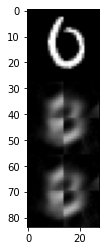

In [ ]:
from torchvision.utils import make_grid
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

batch, _ = next(iter(data_loader))

ae_recon, _ = model(batch.reshape(*batch.shape[:2], 14*14))
ae_recon = ae_recon.reshape(*batch.shape[:2], 14, 14)

encoded = model.encoder(batch.reshape(*batch.shape[:2], 14*14))
encoded_new = depth_wise_model(encoded.squeeze(-1))
recon = model.decoder(encoded_new.unsqueeze(-1))
recon = recon.reshape(*batch.shape[:2], 14, 14)

grid = make_grid(batch[0].unsqueeze(1), padding=0, nrow=2)
grid_ae_recon = make_grid(ae_recon[0].unsqueeze(1), padding=0, nrow=2)
grid_recon = make_grid(recon[0].unsqueeze(1), padding=0, nrow=2)
plt.imshow(torch.cat((grid.permute(1,2,0), grid_recon.permute(1,2,0), grid_ae_recon.permute(1,2,0)), dim=0))